In [42]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots 
from ISLP import load_data
from ISLP import confusion_table
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,auc,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt

# **Predicting insurance policy purchasing pattern: the `Caravan` data**

## Load data and preprocessing

In [43]:
Caravan = load_data('Caravan') #load data
Purchase = Caravan.Purchase 
Purchase.value_counts() #check for data imbalance

No     5474
Yes     348
Name: Purchase, dtype: int64

In [44]:
feature = Caravan.drop(columns=['Purchase'])
feature.std() #check if scaling is needed

MOSTYPE     12.846706
MAANTHUI     0.405842
MGEMOMV      0.789835
MGEMLEEF     0.814589
MOSHOOFD     2.856760
              ...    
AZEILPL      0.022696
APLEZIER     0.081632
AFIETS       0.210986
AINBOED      0.090463
ABYSTAND     0.119996
Length: 85, dtype: float64

In [45]:
(X_train,X_test,y_train,y_test) = train_test_split(feature, Purchase, test_size=0.3, random_state=287) #split training/test sets

In [46]:
scaler = StandardScaler(with_mean=True, with_std=True, copy=True) #scale training and test features
scaler.fit(X_train) #note here we use mean and std of training data to scale training and test data
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

## Use `1NN` for prediction

In [47]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train_sc,y_train).predict(X_test_sc)
np.mean(y_test != knn1_pred), np.mean(y_test != "No") #calculate the classification error, and compare with the proportion of minor class

(0.10875787063537493, 0.06754436176302232)

In [48]:
print(classification_report(y_test, knn1_pred)) #more metrics from classification_report function

              precision    recall  f1-score   support

          No       0.94      0.95      0.94      1629
         Yes       0.12      0.10      0.11       118

    accuracy                           0.89      1747
   macro avg       0.53      0.53      0.53      1747
weighted avg       0.88      0.89      0.89      1747



In [49]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,1545,106
Yes,84,12


In [50]:
12/(84+12) # this suggests that 1NN is better than random guessing

0.125

## Vary the value of `K` to see the change in classification results

In [51]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train_sc, y_train).predict(X_test_sc) 
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to purchase: {1:>2},' +
    ' # who did purchase {2:>2}, precision {3:.1%}') #:d is for integer, :>2 is to align to left, :.1% is to take one decimal place
    pred = C.loc['Yes'].sum()
    did_purchase = C.loc['Yes','Yes'] 
    print(templ.format(
          K,
          pred , did_purchase ,
          did_purchase / pred))

K=1: # predicted to purchase: 96, # who did purchase 12, precision 12.5%
K=2: # predicted to purchase: 16, # who did purchase  2, precision 12.5%
K=3: # predicted to purchase: 34, # who did purchase  5, precision 14.7%
K=4: # predicted to purchase:  9, # who did purchase  2, precision 22.2%
K=5: # predicted to purchase: 14, # who did purchase  4, precision 28.6%


This suggests that results can be very different with different values of `K`.

## Use cross-validation to tune the value of `K`

In [52]:
y_train = y_train.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})

In [53]:
# set tuning values
tuned_parameters = [{"n_neighbors": [1,3,5,7,9]}]
# tune the parameter by k-fold cross-validation
# more details of grid search, see 'https://scikit-learn.org/stable/modules/grid_search.html#exhaustive-grid-search'
knnCV = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='roc_auc',cv=10)
# scoring can be set to f1, precision, recall, roc_auc and many other metrics, depending on the task and data
# more details see 'https://scikit-learn.org/stable/modules/model_evaluation.html'
knnCV.fit(X_train_sc, y_train)
print("Best parameters set found on validation set:")
print()
print(knnCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = knnCV.cv_results_["mean_test_score"]
stds = knnCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, knnCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on validation set:

{'n_neighbors': 9}

Grid scores on validation set:

0.540 (+/-0.036) for {'n_neighbors': 1}
0.559 (+/-0.059) for {'n_neighbors': 3}
0.590 (+/-0.062) for {'n_neighbors': 5}
0.612 (+/-0.050) for {'n_neighbors': 7}
0.624 (+/-0.055) for {'n_neighbors': 9}


In [54]:
# predict test set labels
y_pred_cv = knnCV.predict(X_test_sc)
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1629
           1       1.00      0.01      0.02       118

    accuracy                           0.93      1747
   macro avg       0.97      0.50      0.49      1747
weighted avg       0.94      0.93      0.90      1747



In [55]:
y_scores = knn1.predict_proba(X_test_sc) #obtain ROC curve and AUC value
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

0.5250647688610044

In [56]:
y_scores_cv = knnCV.predict_proba(X_test_sc)
fpr_cv, tpr_cv, threshold_cv = roc_curve(y_test, y_scores_cv[:, 1])
roc_auc_cv = auc(fpr_cv, tpr_cv)
roc_auc_cv

0.6390735711833193

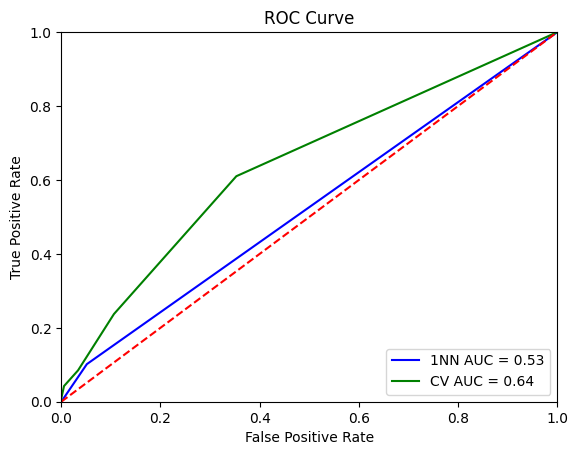

In [57]:
plt.title('Receiver Operating Characteristic') # show two ROC curves on one plot for easy comparison
plt.plot(fpr, tpr, 'b', label = '1NN AUC = %0.2f' % roc_auc)
plt.plot(fpr_cv, tpr_cv, 'g', label = 'CV AUC = %0.2f' % roc_auc_cv)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

Play with different inputs to `scroing`, to see how the final classification results would change.

## Oversample with SMOTE to tackle the imbalanced problem

In [58]:
# install imbalanced learning, a guide here https://imbalanced-learn.org/stable/user_guide.html
# pip install -U imbalanced-learn

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train_sc, y_train)

In [61]:
y_resampled.value_counts() # now we have a balanced dataset

0    3845
1    3845
Name: Purchase, dtype: int64

In [62]:
knnCV_resampled = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='roc_auc',cv=10)
knnCV_resampled.fit(X_resampled, y_resampled)
knnCV_resampled.best_params_

{'n_neighbors': 7}

In [63]:
# predict test set labels
y_pred_resampled = knnCV_resampled.predict(X_test_sc)
print(classification_report(y_test, y_pred_resampled))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83      1629
           1       0.11      0.46      0.18       118

    accuracy                           0.72      1747
   macro avg       0.53      0.60      0.51      1747
weighted avg       0.89      0.72      0.79      1747



In [64]:
y_scores_resampled = knnCV_resampled.predict_proba(X_test_sc)
fpr_resampled, tpr_resampled, threshold_resampled = roc_curve(y_test, y_scores_resampled[:, 1])
roc_auc_resampled = auc(fpr_resampled, tpr_resampled)
roc_auc_resampled

0.6690675364942618

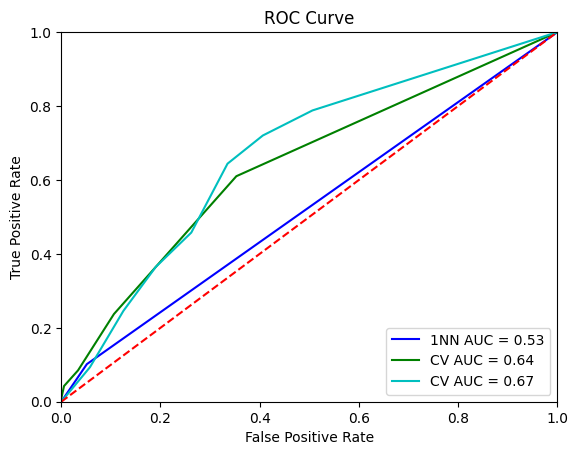

In [65]:
plt.title('Receiver Operating Characteristic') # show two ROC curves on one plot for easy comparison
plt.plot(fpr, tpr, 'b', label = '1NN AUC = %0.2f' % roc_auc)
plt.plot(fpr_cv, tpr_cv, 'g', label = 'CV AUC = %0.2f' % roc_auc_cv)
plt.plot(fpr_resampled, tpr_resampled, 'c', label = 'CV AUC = %0.2f' % roc_auc_resampled)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

SMOTE helps in this case!